In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o', streaming=True)
small_llm = ChatOpenAI(model='gpt-4o-mini', streaming=True)

In [3]:
from langchain_core.tools import tool

@tool
def add(a: int, b: int) -> int:
    """숫자 a와 b를 더합니다."""
    return a + b

@tool
def multiply(a: int, b: int) -> int:
    """숫자 a와 b를 곱합니다."""
    return a * b

In [4]:
from langgraph.prebuilt import ToolNode

tool_list = [add, multiply]
llm_with_tools = llm.bind_tools(tool_list) # 2개의 tool을 가지고 있다고 보면 된다.
tool_node = ToolNode(tool_list)

In [5]:
ai_message = llm_with_tools.invoke('What is 3 plus 5?')

In [6]:
ai_message

AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_LL0o0sM8XqHSptEYzh9xXeKw', 'function': {'arguments': '{"a":3,"b":5}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f33640a400'}, id='run--2d7d58e0-85e3-4e36-b564-cbd5ea7f11b2-0', tool_calls=[{'name': 'add', 'args': {'a': 3, 'b': 5}, 'id': 'call_LL0o0sM8XqHSptEYzh9xXeKw', 'type': 'tool_call'}])

In [7]:
 # tool_node는 toll 호출할떄 사용 tool중 알아서 어떤 tool을 호출할지 스스로 판단

tool_node.invoke({'messages': [ai_message]})

{'messages': [ToolMessage(content='8', name='add', tool_call_id='call_LL0o0sM8XqHSptEYzh9xXeKw')]}

In [8]:
from langgraph.graph import MessagesState, StateGraph #tool 사용시 MessagesState 필수

# class AgentState(MessagesState) 이것을 사용 안해도 밑에 있는걸 사용하면 가능
graph_builder = StateGraph(MessagesState) # messages 존재 
# messages라는 속성을 사용가능하게 된다(존재한다는 것을 알림)

In [9]:
def agent(state: MessagesState) -> MessagesState:
    messages = state['messages']
    response = llm_with_tools.invoke(messages)

    return{'messages': [response]}

In [10]:
from typing import Literal
from langgraph.graph import END

def should_continue(state: MessagesState) -> Literal['tools', END]:
    messages = state['messages']
    last_ai_message = messages[-1]

    if last_ai_message.tool_calls:
        return 'tools'
    
    return END

In [11]:
graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node) # tool_node node로 사용가능? 가능하다? 왜?

### 2가지 방법중 하나 선택 둘다 가능


    'agent',
    should_continue,
    ['tools', END]
    
     should_continue,
     {
         'tools': "tools",
         'end': END
     }

In [12]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges(
    'agent',
    should_continue,
    ['tools', END]

)

graph_builder.add_edge('tools', 'agent')

In [13]:
graph = graph_builder.compile()

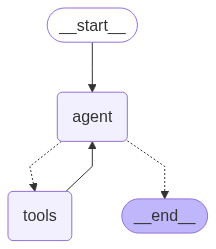

In [14]:
graph

In [15]:
from langchain_core.messages import HumanMessage

for chunk in graph.stream({'messages': [HumanMessage('3에다 5를 더하고 거기에 8을 곱하면?')]}, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

3에다 5를 더하고 거기에 8을 곱하면?
================================== Ai Message ==================================
Tool Calls:
  add (call_AjDsCs8FHTYbXlByzbqsnkGW)
 Call ID: call_AjDsCs8FHTYbXlByzbqsnkGW
  Args:
    a: 3
    b: 5
  multiply (call_OWBZW8sfWXUuEqpXpX8EuBPq)
 Call ID: call_OWBZW8sfWXUuEqpXpX8EuBPq
  Args:
    a: 8
    b: 8
================================= Tool Message =================================
Name: multiply

64
================================== Ai Message ==================================
Tool Calls:
  multiply (call_XpMxyjtlH0temMe95RJwyl7N)
 Call ID: call_XpMxyjtlH0temMe95RJwyl7N
  Args:
    a: 8
    b: 8
================================= Tool Message =================================
Name: multiply

64
================================== Ai Message ==================================

3에 5를 더하면 8이 되고, 거기에 8을 곱하면 64가 됩니다.


### GOOGLE

In [16]:
from langchain_community.tools import DuckDuckGoSearchRun

search_tool = DuckDuckGoSearchRun()

In [17]:
from langchain_google_community import GmailToolkit
from langchain_google_community.gmail.utils import (
    build_resource_service,
    get_gmail_credentials,
)

credentials = get_gmail_credentials(
    token_file="./google/google_token.json",    # 이 파일을 만들어달라는 뜻
    scopes=["https://mail.google.com/"],
    client_secrets_file="./google/google_credentials.json",
)
api_resource = build_resource_service(credentials=credentials)
gmail_toolkit = GmailToolkit(api_resource=api_resource)
gmail_tool_list = gmail_toolkit.get_tools()

In [18]:
gmail_tool_list

[GmailCreateDraft(api_resource=<googleapiclient.discovery.Resource object at 0x0000027356DB2C10>),
 GmailSendMessage(api_resource=<googleapiclient.discovery.Resource object at 0x0000027356DB2C10>),
 GmailSearch(api_resource=<googleapiclient.discovery.Resource object at 0x0000027356DB2C10>),
 GmailGetMessage(api_resource=<googleapiclient.discovery.Resource object at 0x0000027356DB2C10>),
 GmailGetThread(api_resource=<googleapiclient.discovery.Resource object at 0x0000027356DB2C10>)]

In [19]:
from langgraph.prebuilt import ToolNode

tool_list = [add, multiply, search_tool] + gmail_tool_list
llm_with_tools = llm.bind_tools(tool_list)
tool_node = ToolNode(tool_list)

In [20]:
from langgraph.graph import MessagesState, StateGraph #tool 사용시 MessagesState 필수

# class AgentState(MessagesState) 이것을 사용 안해도 밑에 있는걸 사용하면 가능
graph_builder = StateGraph(MessagesState) # messages 존재 
# messages라는 속성을 사용가능하게 된다(존재한다는 것을 알림)

In [21]:
def agent(state: MessagesState) -> MessagesState:
    messages = state['messages']
    response = llm_with_tools.invoke(messages)

    return{'messages': [response]}

In [22]:
from typing import Literal
from langgraph.graph import END

def should_continue(state: MessagesState) -> Literal['tools', END]:
    messages = state['messages']
    last_ai_message = messages[-1]

    if last_ai_message.tool_calls:
        return 'tools'
    
    return END

In [23]:
graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node) # tool_node node로 사용가능? 가능하다? 왜?

In [24]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges(
    'agent',
    should_continue,
    ['tools', END]

)

graph_builder.add_edge('tools', 'agent')

In [25]:
graph = graph_builder.compile()

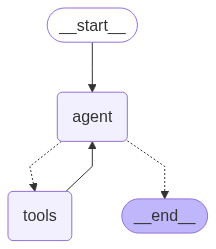

In [26]:
graph

In [ ]:
from langchain_core.messages import HumanMessage

query = '김지수의 출생지에는 어떤 통화를 사용하나요? 어떤 통화인지 찾아서 0-0 이메일로 보내주세요'

from langchain_core.messages import HumanMessage

for chunk in graph.stream({'messages': [HumanMessage(query)]}, stream_mode='values'):
    chunk['messages'][-1].pretty_print()


================================ Human Message =================================

김지수의 출생지에는 어떤 통화를 사용하나요? 어떤 통화인지 찾아서 rmfhrm9@gmail.com 이메일로 보내주세요
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_VptUmiQz1W98BmdwQ1jypTl6)
 Call ID: call_VptUmiQz1W98BmdwQ1jypTl6
  Args:
    query: 김지수 출생지
  duckduckgo_search (call_9ohpdYMNKG4XVj1zX9ijjZSS)
 Call ID: call_9ohpdYMNKG4XVj1zX9ijjZSS
  Args:
    query: South Korea currency


c:\workspace\uv_work\.venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:64: UserWarning: 'api' backend is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(
c:\workspace\uv_work\.venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:64: UserWarning: 'api' backend is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


================================= Tool Message =================================
Name: duckduckgo_search

The South Korean won, sometimes known as the Republic of Korea won is the official currency of South Korea. A single won is divided into 100 jeon, ... The South Korean won is the official currency of South Korea. Its currency code is KRW and its symbol is ₩. The won's conversion factor goes to 6 significant ... Coins come in 1, 5, 10, 100, and 500 won (1 and 5 won coins are not widely circulated). Korea's Bills. 1,000 won (cheon won). 1,000 won Front. Front. 1,000 won ... Our currency rankings show that the most popular South Korean Won exchange rate is the KRW to USD rate. The currency code for South Korean Won is KRW. The currency of Korea is the won (₩; KRW). You can easily exchange foreign currencies into Korean won at banks' exchange offices in the airport, banks in ...
================================== Ai Message ==================================
Tool Calls:
  send_gmail_me